# Interpret regression models using California Housing Prices Dataset

该笔记本演示了如何在回归模型上应用“Captum”库，并了解有助于预测的重要特征、层/神经元。它比较了“Captum”库中的许多归因算法，用于在著名的加州房价数据集的子样本上训练的简单 DNN 模型。

请注意，为了能够成功运行此笔记本，您需要提前安装 scikit-learn 包。


In [1]:
import numpy as np

from os import path


import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation


## Data loading and pre-processing

让我们从 scikit-learn 库加载加州房价数据集和相应的标签。

In [15]:
california = fetch_california_housing()
# print(california.data.shape)

# https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset
feature_names = california.feature_names
# print(feature_names)
"""
Features:
MedInc median income in block group
HouseAge median house age in block group
AveRooms average number of rooms per household
AveBedrms average number of bedrooms per household
Population block group population
AveOccup average number of household members
Latitude block group latitude
Longitude block group longitude
 
The target variable is the median house value for California districts, 
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census block group. 
A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data 
(a block group typically has a population of 600 to 3,000 people).
"""

#take first n examples for speed up
n = 600
X = california.data[:n]
y = california.target[:n]
print(X.shape)
print(y.shape)

(20640, 8)
(600, 8)
(600,)


In order to retain deterministic results, let's fix the seeds.

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)


Let's use 70% of our data for training and the remaining 30% for testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# Data Exploration

让我们在单独的图中可视化因变量与每个自变量。除此之外，我们还将执行简单的回归分析，并以红色虚线绘制拟合线。

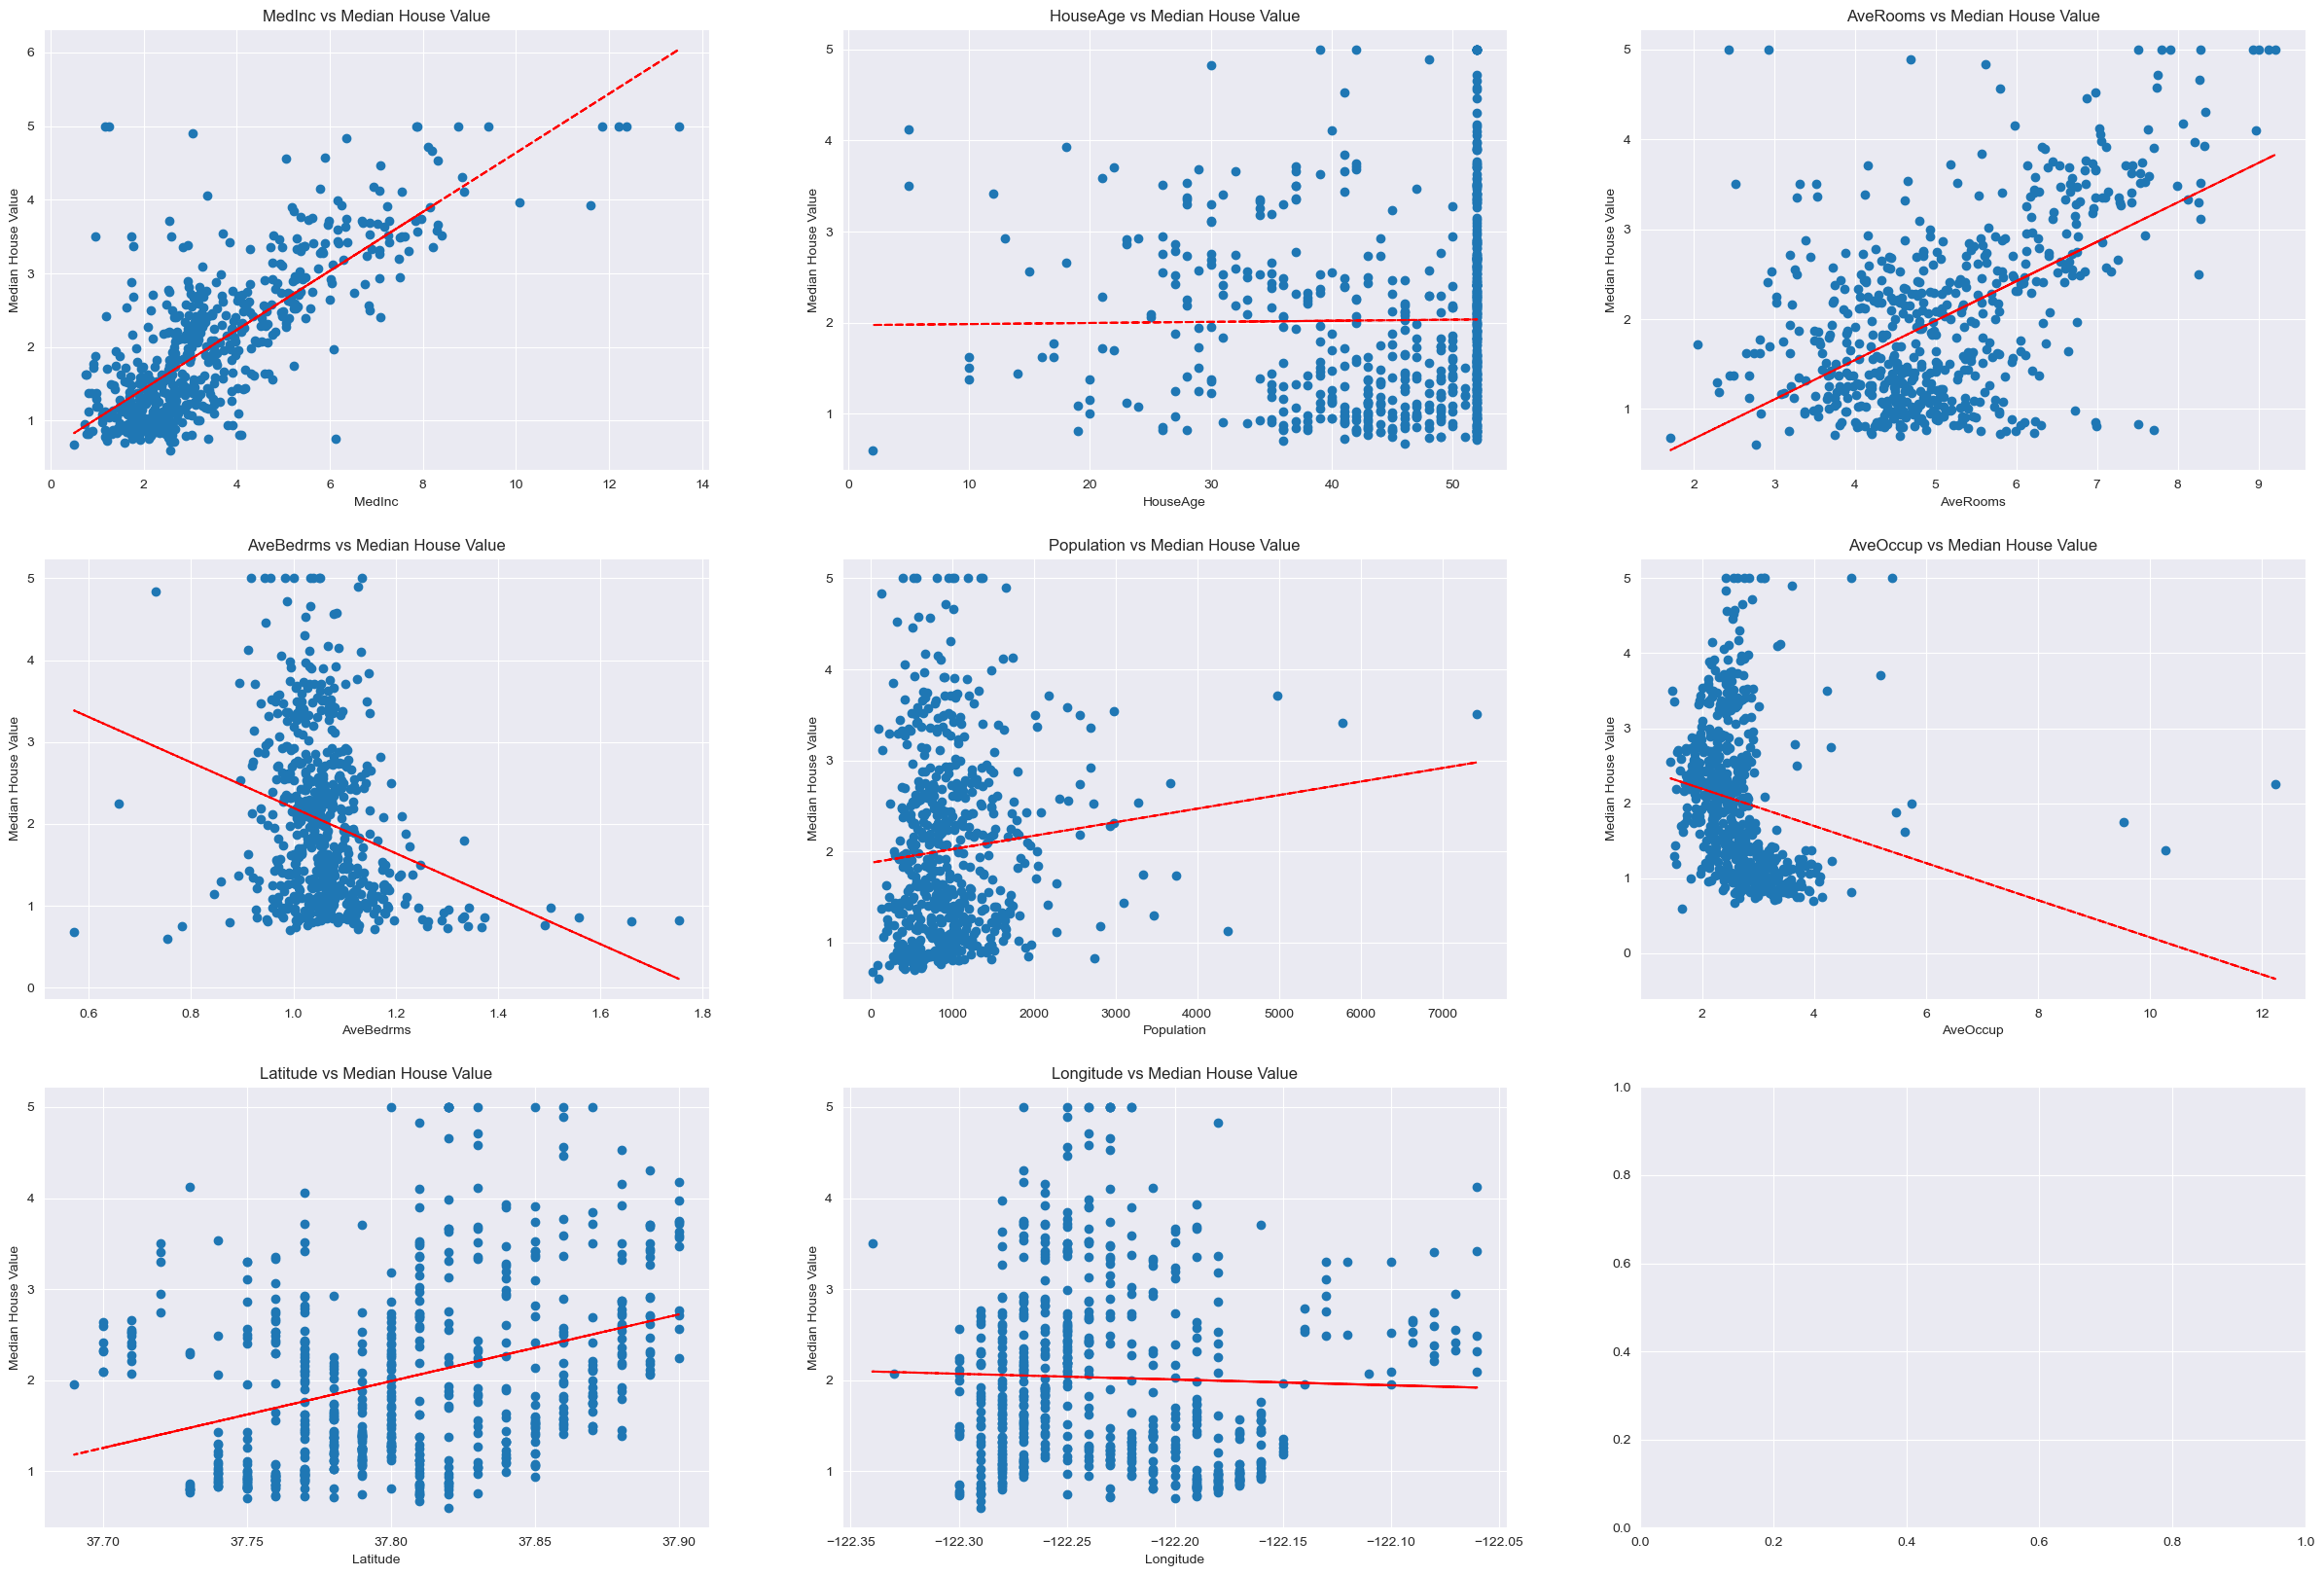

In [18]:
fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):    
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Median House Value')
    ax.set_xlabel(col)
    ax.set_ylabel('Median House Value')

From the diagram above we can tell that some of the most influential features that are correlated with the output average house value are:   
   - MedInc, median income in block group
     If MedInc increases the house value increases too.
   - AveRooms, average number of rooms per household.
     This variable is positively correlated with the house value. The higher the average number of rooms per household the higher the average value of the house.     

# Tensorizing inputs and creating batches

Below we tensorize input features and corresponding labels.


In [16]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
print(X_test.shape)
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)


torch.Size([180, 8])


C:\Users\zzy\AppData\Local\Temp\ipykernel_8040\1937633528.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\zzy\AppData\Local\Temp\ipykernel_8040\1937633528.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).view(-1, 1).float()
C:\Users\zzy\AppData\Local\Temp\ipykernel_8040\1937633528.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\zzy\AppData\Local\Temp\ipykernel_8040\1937633528.py:6: UserWarning: To copy

Defining default hyper parameters for the model.


In [23]:
batch_size = 50
num_epochs = 200
learning_rate = 0.0001
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_hidden4 = 1

We define a four layer neural network containing ReLUs between each linear layer. This network is slightly more complex than the standard linear regression model and results in a slightly better accuracy.

In [21]:
class CaliforniaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(8, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))


In [24]:
model = CaliforniaModel()
model.train()


CaliforniaModel(
  (lin1): Linear(in_features=8, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

## Train California Model

Defining the loss function that will be used for optimization.

In [94]:
criterion = nn.MSELoss(reduction='sum')

Defining the training function that contains the training loop and uses RMSprop and given input hyper-parameters to train the model defined in the cell above.

In [95]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0


If the model was previously trained and stored, we load that pre-trained model, otherwise, we train a new model and store it for future uses.

Models can found here: https://github.com/pytorch/captum/tree/master/tutorials/models

In [96]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [98]:
SAVED_MODEL_PATH = 'models/california_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH)

Epoch [1]/[200] running accumulative loss across all batches: 15496.155
Epoch [21]/[200] running accumulative loss across all batches: 448.178
Epoch [41]/[200] running accumulative loss across all batches: 408.678
Epoch [61]/[200] running accumulative loss across all batches: 397.588
Epoch [81]/[200] running accumulative loss across all batches: 341.604
Epoch [101]/[200] running accumulative loss across all batches: 319.684
Epoch [121]/[200] running accumulative loss across all batches: 262.656
Epoch [141]/[200] running accumulative loss across all batches: 200.881
Epoch [161]/[200] running accumulative loss across all batches: 195.418
Epoch [181]/[200] running accumulative loss across all batches: 173.983
Finished training the model. Saving the model to the path: models/california_model.pt


Let's perform a simple sanity check and compute the performance of the model using Root Squared Mean Error (RSME) metric.

In [99]:
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  0.65797454


# Comparing different attribution algorithms

让我们使用核心“Captum”库中的不同归因算法来计算与模型输入相关的归因，并可视化这些归因。为此，我们使用上面单元格中定义的测试数据集。

对于所有算法，我们主要使用默认设置，例如默认基线、步数等，但欢迎您使用这些设置。具体来说，对于GradientSHAP来说，我们使用整个训练数据集作为基线的分布。

注意：请耐心等待！下面单元格的执行需要半分钟。

In [25]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)


D:\Envirenment\Anaconda\envs\pytorch\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
D:\Envirenment\Anaconda\envs\pytorch\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Now let's visualize attribution scores with respect to inputs (using test dataset) for our simple model in one plot. This will help us to understand how similar or different the attribution scores assigned from different attribution algorithms are. Apart from that we will also compare attribution scores with the learned model weights.

It is important to note the we aggregate the attributions across the entire test dataset in order to retain a global view of feature importance. This, however, is not ideal since the attributions can cancel out each other when we aggregate then across multiple samples.

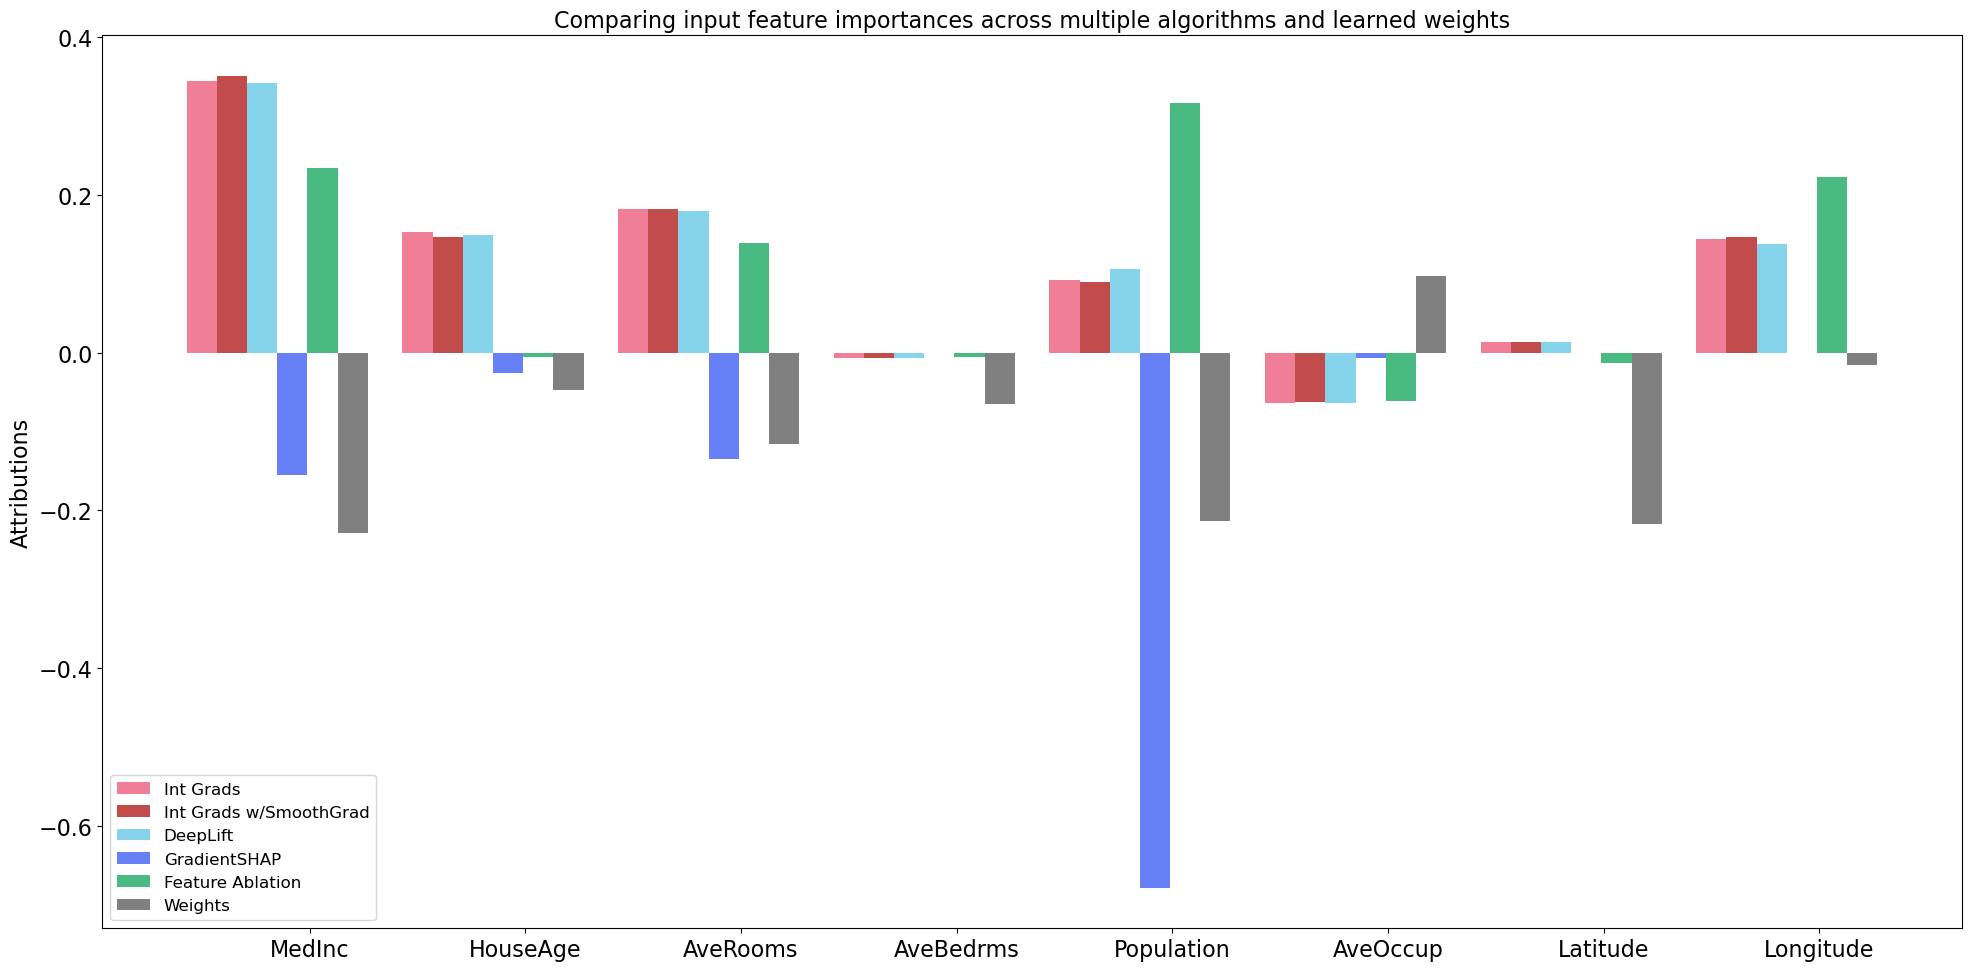

In [102]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()


The magnitudes of learned model weights tell us about the correlations between the dependent variable `Avg House Value` and each independent variable. Zero weight means no correlation whereas positive weights indicate positive correlations and negatives the opposite. Since the network has more than one layer these weights might not be directly correlated with the price.

From the plot above we can see that attribution algorithms sometimes disagree on assigning importance scores and that they are not always aligned with weights. However, we can still observe that two of the top important features: `MedInc`, and `AveRooms` are also considered to be important based on both most attribution algorithms and the weight scores.

It is interesting to observe that the feature `Population` has high positive attribution score based on some of the attribution algorithms. This can be related, for example, to the choice of the baseline. In this tutorial we use zero-valued baselines for all features, however if we were to choose those values more carefully for each feature the picture will change. Similar arguments apply also when the signs of the weights and attributions mismatches or when one algorithm assigns higher or lower attribution scores compare to the others.

In terms of least important features, we observe that `AveBedrms` and `AveOccup` are voted to be least important both based on most attribution algorithms and learned coefficients.

Another interesting observation is that both Integrated Gradients and DeepLift return similar attribution scores across all features. This is associated with the fact that although we have non-linearities in our model, their effects aren't significant and DeepLift is close to `(input - baselines) * gradients`. And because the gradients do not change significantly along the straight line from baseline to input, we observe similar situation with Integrated Gradients as well.

We also note that GradientShap behaves differently than the other methods for this data and model.  Whereas the other methods in this tutorial are calculated on test inputs and a reference baseline of zero, GradientShap is calculated with a baseline of the training distribution which might be the cause of the behavior observed.

## Attributing to the layers and comparing with model weights

Now let's beside attributing to the inputs of the model, also attribute to the layers of the model and understand which neurons appear to be more important.

In the cell below we will attribute to the inputs of the second linear layer of our model. Similar to the previous case, the attribution is performed on the test dataset.

In [103]:
# Compute the attributions of the output with respect to the inputs of the fourth linear layer
lc = LayerConductance(model, model.lin4)

# shape: test_examples x size_hidden
lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

# weights from forth linear layer
# shape: size_hidden4 x size_hidden3
lin4_weight = model.lin4.weight

In the cell below we normalize and visualize the attributions and learned model weights for all 10 neurons in the fourth hidden layer. 
The weights represent the weight matrix of the fourth linear layer. The attributions are computed with respect to the inputs of the fourth linear layer.

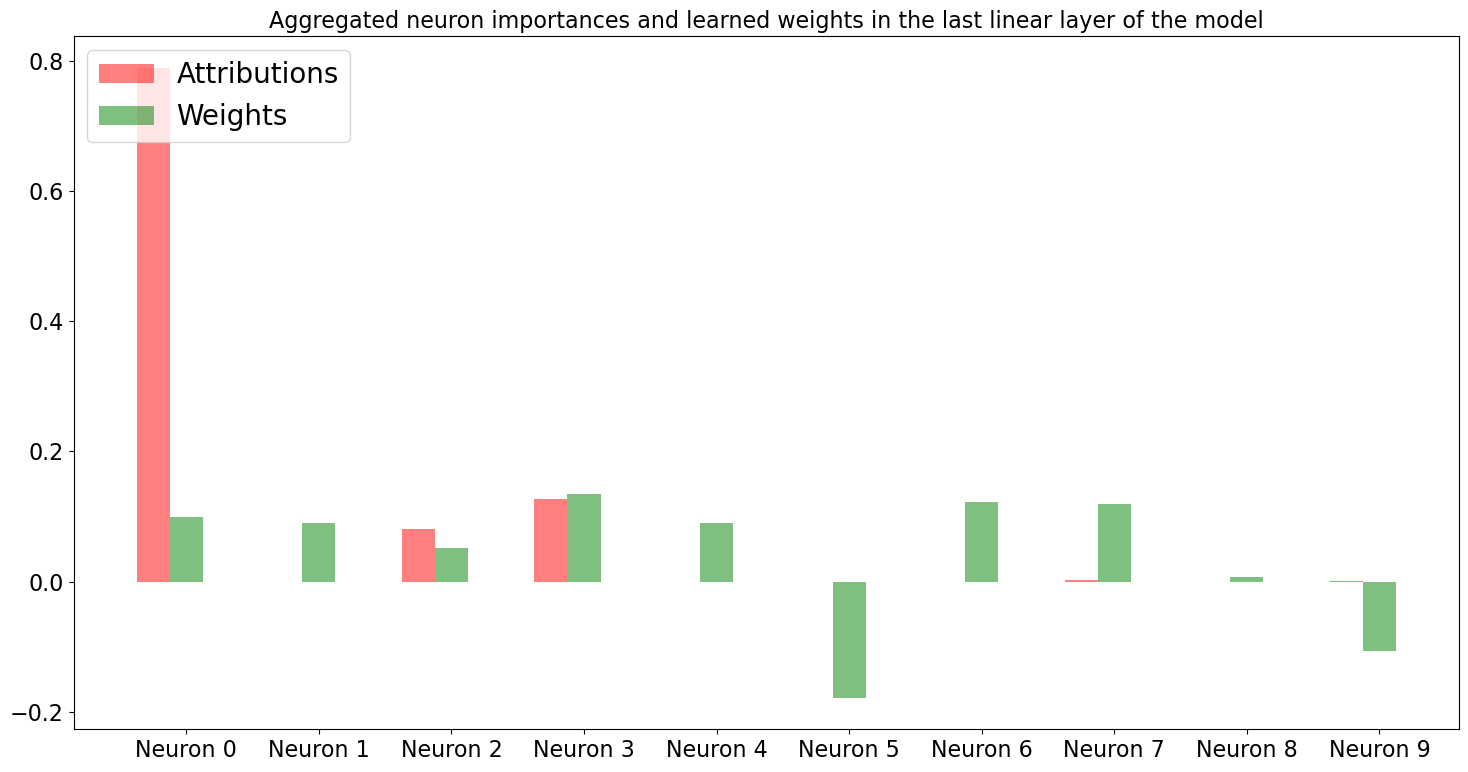

In [104]:
plt.figure(figsize=(15, 8))

x_axis_data = np.arange(lc_attr_test.shape[1])

y_axis_lc_attr_test = lc_attr_test.mean(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin4_weight = lin4_weight[0].detach().numpy()
y_axis_lin4_weight = y_axis_lin4_weight / np.linalg.norm(y_axis_lin4_weight, ord=1)

width = 0.25
legends = ['Attributions','Weights']
x_axis_labels = [ 'Neuron {}'.format(i) for i in range(len(y_axis_lin4_weight))]

ax = plt.subplot()
ax.set_title('Aggregated neuron importances and learned weights in the last linear layer of the model')

ax.bar(x_axis_data + width, y_axis_lc_attr_test, width, align='center', alpha=0.5, color='red')
ax.bar(x_axis_data + 2 * width, y_axis_lin4_weight, width, align='center', alpha=0.5, color='green')
plt.legend(legends, loc=2, prop={'size': 20})
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_labels)

plt.show()


It is interesting to observe that the attribution scores for the 10 neurons in the last layer are spread between half of the weights and all have positive attribution scores.

We also observe that the neurons five and six have very small attributions but relatively larger weights. Another interesting thing to observe is that the weights do not fluctuate much whereas attributions do fluctuate more relative to that and spike in Neuron 0.